##### Copyright 2020 The TensorFlow Authors.

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# MNIST classification

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/quantum/tutorials/mnist"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/quantum/blob/master/docs/tutorials/mnist.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/quantum/blob/master/docs/tutorials/mnist.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/quantum/docs/tutorials/mnist.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

This tutorial builds a quantum neural network (QNN) to classify a simplified version of MNIST, similar to the approach used in <a href="https://arxiv.org/pdf/1802.06002.pdf" class="external">Farhi et al</a>. The performance of the quantum neural network on this classical data problem is compared with a classical neural network.

## Setup

In [2]:
!pip install tensorflow==2.7.0

  Obtaining dependency information for protobuf>=3.9.2 from https://files.pythonhosted.org/packages/ae/5b/7ed02a9b8e752c8f7bca8661779c0275b9e3e6a903a3045e6da51f796dda/protobuf-4.25.1-cp37-abi3-manylinux2014_x86_64.whl.metadata
  Using cached protobuf-4.25.1-cp37-abi3-manylinux2014_x86_64.whl.metadata (541 bytes)
  Obtaining dependency information for google-auth<3,>=1.6.3 from https://files.pythonhosted.org/packages/f4/d2/9f6f3b9c0fd486617816cff42e856afea079d0bad99f0e60dc186c76b881/google_auth-2.25.2-py2.py3-none-any.whl.metadata
  Using cached google_auth-2.25.2-py2.py3-none-any.whl.metadata (4.7 kB)
Using cached protobuf-4.25.1-cp37-abi3-manylinux2014_x86_64.whl (294 kB)
Using cached google_auth-2.25.2-py2.py3-none-any.whl (184 kB)
  Attempting uninstall: protobuf
    Found existing installation: protobuf 3.17.3
    Uninstalling protobuf-3.17.3:
      Successfully uninstalled protobuf-3.17.3
  Attempting uninstall: google-auth
    Found existing installation: google-auth 1.18.0
    U

Install TensorFlow Quantum:

In [3]:
!pip install tensorflow-quantum==0.7.2

  Using cached google_auth-1.18.0-py2.py3-none-any.whl (90 kB)
  Using cached protobuf-3.17.3-cp38-cp38-manylinux_2_5_x86_64.manylinux1_x86_64.whl (1.0 MB)
  Attempting uninstall: protobuf
    Found existing installation: protobuf 4.25.1
    Uninstalling protobuf-4.25.1:
      Successfully uninstalled protobuf-4.25.1
  Attempting uninstall: google-auth
    Found existing installation: google-auth 2.25.2
    Uninstalling google-auth-2.25.2:
      Successfully uninstalled google-auth-2.25.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-auth-oauthlib 1.0.0 requires google-auth>=2.15.0, but you have google-auth 1.18.0 which is incompatible.
tensorboard 2.14.0 requires protobuf>=3.19.6, but you have protobuf 3.17.3 which is incompatible.

[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: pip install --upgrade pip


In [4]:
!pip install seaborn


[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: pip install --upgrade pip


In [5]:
# Update package resources to account for version changes.
import importlib, pkg_resources
importlib.reload(pkg_resources)

<module 'pkg_resources' from '/home/henrique/Documentos/quantum/.venv/lib/python3.8/site-packages/pkg_resources/__init__.py'>

Now import TensorFlow and the module dependencies:

In [6]:
import tensorflow as tf
import tensorflow_quantum as tfq

import cirq
import sympy
import numpy as np
import seaborn as sns
import collections

# visualization tools
%matplotlib inline
import matplotlib.pyplot as plt
from cirq.contrib.svg import SVGCircuit

2023-12-18 21:11:20.363889: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-12-18 21:11:20.363916: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-12-18 21:11:24.335800: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2023-12-18 21:11:24.335870: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (henrique-MS-7C37): /proc/driver/nvidia/version does not exist
2023-12-18 21:11:24.336652: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AV

## 1. Load the data

In this tutorial you will build a binary classifier to distinguish between the digits 3 and 6, following <a href="https://arxiv.org/pdf/1802.06002.pdf" class="external">Farhi et al.</a> This section covers the data handling that:

- Loads the raw data from Keras.
- Filters the dataset to only 3s and 6s.
- Downscales the images so they fit can fit in a quantum computer.
- Removes any contradictory examples.
- Converts the binary images to Cirq circuits.
- Converts the Cirq circuits to TensorFlow Quantum circuits. 

### 1.1 Load the raw data

Load the MNIST dataset distributed with Keras. 

In [7]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

# Rescale the images from [0,255] to the [0.0,1.0] range.
x_train, x_test = x_train[..., np.newaxis]/255.0, x_test[..., np.newaxis]/255.0

print("Number of original training examples:", len(x_train))
print("Number of original test examples:", len(x_test))

Number of original training examples: 60000
Number of original test examples: 10000


Filter the dataset to keep just the 3s and 6s,  remove the other classes. At the same time convert the label, `y`, to boolean: `True` for `3` and `False` for 6. 

In [8]:
def filter_36(x, y):
    keep = (y == 3) | (y == 6)
    x, y = x[keep], y[keep]
    y = y == 3
    return x,y

In [9]:
x_train, y_train = filter_36(x_train, y_train)
x_test, y_test = filter_36(x_test, y_test)

print("Number of filtered training examples:", len(x_train))
print("Number of filtered test examples:", len(x_test))

Number of filtered training examples: 12049
Number of filtered test examples: 1968


Show the first example:

True


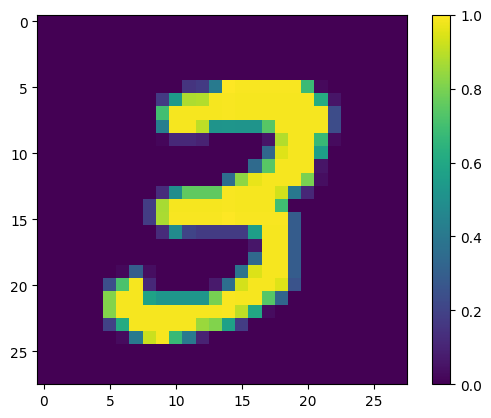

In [10]:
print(y_train[0])

plt.imshow(x_train[0, :, :, 0])
plt.colorbar()

### 1.2 Downscale the images

An image size of 28x28 is much too large for current quantum computers. Resize the image down to 4x4:

In [52]:
# Utilizando vários métodos de redução de dimensionalidade

x_train_hat_tent = tf.image.resize(x_train, (4,4), method='bilinear', antialias=True).numpy()
x_test_hat_tent = tf.image.resize(x_test, (4,4), method='bilinear', antialias=True).numpy()

x_train_bilinear = tf.image.resize(x_train, (4,4), method='bilinear').numpy()
x_test_bilinear = tf.image.resize(x_test, (4,4), method='bilinear').numpy()

x_train_lanczos3 = tf.image.resize(x_train, (4,4), method='lanczos3').numpy()
x_test_lanczos3 = tf.image.resize(x_test, (4,4), method='lanczos3').numpy()

x_train_lanczos5 = tf.image.resize(x_train, (4,4), method='lanczos5').numpy()
x_test_lanczos5 = tf.image.resize(x_test, (4,4), method='lanczos5').numpy()

x_train_mitchellcubic = tf.image.resize(x_train, (4,4), method='mitchellcubic').numpy()
x_test_mitchellcubic = tf.image.resize(x_test, (4,4), method='mitchellcubic').numpy()

x_train_nearest = tf.image.resize(x_train, (4,4), method='nearest').numpy()
x_test_nearest = tf.image.resize(x_test, (4,4), method='nearest').numpy()

x_train_area = tf.image.resize(x_train, (4,4), method='area').numpy()
x_test_area = tf.image.resize(x_test, (4,4), method='area').numpy()

x_train_gaussian = tf.image.resize(x_train, (4,4), method='gaussian').numpy()
x_test_gaussian = tf.image.resize(x_test, (4,4), method='gaussian').numpy()

x_train_bicubic = tf.image.resize(x_train, (4,4), method='bicubic').numpy()
x_test_bicubic = tf.image.resize(x_test, (4,4), method='bicubic').numpy()

x_train_small = tf.image.resize(x_train, (4,4)).numpy()
x_test_small = tf.image.resize(x_test, (4,4)).numpy()

Again, display the first training example—after resize: 

True


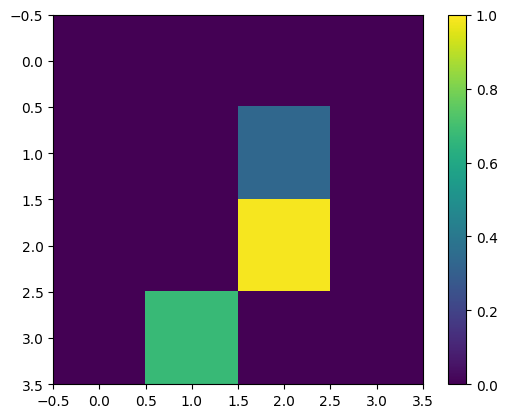

In [12]:
print(y_train[0])

plt.imshow(x_train_small[0,:,:,0], vmin=0, vmax=1)
plt.colorbar()

### 1.3 Remove contradictory examples

From section *3.3 Learning to Distinguish Digits* of <a href="https://arxiv.org/pdf/1802.06002.pdf" class="external">Farhi et al.</a>, filter the dataset to remove images that are labeled as belonging to both classes.

This is not a standard machine-learning procedure, but is included in the interest of following the paper.

In [13]:
def remove_contradicting(xs, ys):
    return xs, ys
    mapping = collections.defaultdict(set)
    orig_x = {}
    # Determine the set of labels for each unique image:
    for x,y in zip(xs,ys):
       orig_x[tuple(x.flatten())] = x
       mapping[tuple(x.flatten())].add(y)
    
    new_x = []
    new_y = []
    for flatten_x in mapping:
      x = orig_x[flatten_x]
      labels = mapping[flatten_x]
      if len(labels) == 1:
          new_x.append(x)
          new_y.append(next(iter(labels)))
      else:
          # Throw out images that match more than one label.
          pass
    
    num_uniq_3 = sum(1 for value in mapping.values() if len(value) == 1 and True in value)
    num_uniq_6 = sum(1 for value in mapping.values() if len(value) == 1 and False in value)
    num_uniq_both = sum(1 for value in mapping.values() if len(value) == 2)

    print("Number of unique images:", len(mapping.values()))
    print("Number of unique 3s: ", num_uniq_3)
    print("Number of unique 6s: ", num_uniq_6)
    print("Number of unique contradicting labels (both 3 and 6): ", num_uniq_both)
    print()
    print("Initial number of images: ", len(xs))
    print("Remaining non-contradicting unique images: ", len(new_x))
    
    return np.array(new_x), np.array(new_y)

The resulting counts do not closely match the reported values, but the exact procedure is not specified.

It is also worth noting here that applying filtering contradictory examples at this point does not totally prevent the model from receiving contradictory training examples: the next step binarizes the data which will cause more collisions. 

In [14]:
x_train_nocon, y_train_nocon = remove_contradicting(x_train_small, y_train)

Number of unique images: 10387
Number of unique 3s:  4912
Number of unique 6s:  5426
Number of unique contradicting labels (both 3 and 6):  49

Initial number of images:  12049
Remaining non-contradicting unique images:  10338


### 1.4 Encode the data as quantum circuits

To process images using a quantum computer, <a href="https://arxiv.org/pdf/1802.06002.pdf" class="external">Farhi et al.</a> proposed representing each pixel with a qubit, with the state depending on the value of the pixel. The first step is to convert to a binary encoding.

In [15]:
THRESHOLD = 0.5

x_train_bin = np.array(x_train_nocon > THRESHOLD, dtype=np.float32)
x_test_bin = np.array(x_test_small > THRESHOLD, dtype=np.float32)

If you were to remove contradictory images at this point you would be left with only 193, likely not enough for effective training.

In [16]:
_ = remove_contradicting(x_train_bin, y_train_nocon)

Number of unique images: 193
Number of unique 3s:  80
Number of unique 6s:  69
Number of unique contradicting labels (both 3 and 6):  44

Initial number of images:  10338
Remaining non-contradicting unique images:  149


The qubits at pixel indices with values that exceed a threshold, are rotated through an $X$ gate.

In [17]:
def convert_to_circuit(image):
    """Encode truncated classical image into quantum datapoint."""
    values = np.ndarray.flatten(image)
    qubits = cirq.GridQubit.rect(4, 4)
    circuit = cirq.Circuit()
    for i, value in enumerate(values):
        if value:
            circuit.append(cirq.X(qubits[i]))
    return circuit


x_train_circ = [convert_to_circuit(x) for x in x_train_bin]
x_test_circ = [convert_to_circuit(x) for x in x_test_bin]

Here is the circuit created for the first example (circuit diagrams do not show qubits with zero gates):

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


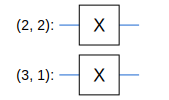

In [18]:
SVGCircuit(x_train_circ[0])

Compare this circuit to the indices where the image value exceeds the threshold:

In [19]:
bin_img = x_train_bin[0,:,:,0]
indices = np.array(np.where(bin_img)).T
indices

array([[2, 2],
       [3, 1]])

Convert these `Cirq` circuits to tensors for `tfq`:

In [20]:
x_train_tfcirc = tfq.convert_to_tensor(x_train_circ)
x_test_tfcirc = tfq.convert_to_tensor(x_test_circ)

## 2. Quantum neural network

There is little guidance for a quantum circuit structure that classifies images. Since the classification is based on the expectation of the readout qubit, <a href="https://arxiv.org/pdf/1802.06002.pdf" class="external">Farhi et al.</a> propose using two qubit gates, with the readout qubit always acted upon. This is similar in some ways to running small a <a href="https://arxiv.org/abs/1511.06464" class="external">Unitary RNN</a> across the pixels.

### 2.1 Build the model circuit

This following example shows this layered approach. Each layer uses *n* instances of the same gate, with each of the data qubits acting on the readout qubit.

Start with a simple class that will add a layer of these gates to a circuit:

In [21]:
class CircuitLayerBuilder():
    def __init__(self, data_qubits, readout):
        self.data_qubits = data_qubits
        self.readout = readout
    
    def add_layer(self, circuit, gate, prefix):
        for i, qubit in enumerate(self.data_qubits):
            symbol = sympy.Symbol(prefix + '-' + str(i))
            circuit.append(gate(qubit, self.readout)**symbol)

Build an example circuit layer to see how it looks:

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


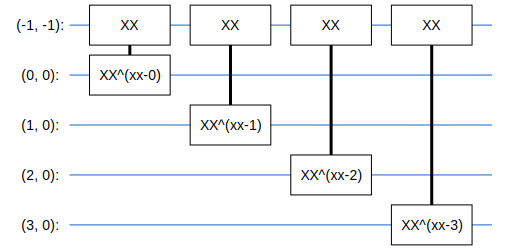

In [22]:
demo_builder = CircuitLayerBuilder(data_qubits = cirq.GridQubit.rect(4,1),
                                   readout=cirq.GridQubit(-1,-1))

circuit = cirq.Circuit()
demo_builder.add_layer(circuit, gate = cirq.XX, prefix='xx')
SVGCircuit(circuit)

Now build a two-layered model, matching the data-circuit size, and include the preparation and readout operations.

In [23]:
def create_quantum_model():
    """Create a QNN model circuit and readout operation to go along with it."""
    data_qubits = cirq.GridQubit.rect(4, 4)  # a 4x4 grid.
    readout = cirq.GridQubit(-1, -1)         # a single qubit at [-1,-1]
    circuit = cirq.Circuit()
    
    # Prepare the readout qubit.
    circuit.append(cirq.X(readout))
    circuit.append(cirq.H(readout))
    
    builder = CircuitLayerBuilder(
        data_qubits = data_qubits,
        readout=readout)

    # Then add layers (experiment by adding more).
    builder.add_layer(circuit, cirq.XX, "xx1")
    builder.add_layer(circuit, cirq.ZZ, "zz1")

    # Finally, prepare the readout qubit.
    circuit.append(cirq.H(readout))

    return circuit, cirq.Z(readout)

In [24]:
model_circuit, model_readout = create_quantum_model()

### 2.2 Wrap the model-circuit in a tfq-keras model

Build the Keras model with the quantum components. This model is fed the "quantum data", from `x_train_circ`, that encodes the classical data. It uses a *Parametrized Quantum Circuit* layer, `tfq.layers.PQC`, to train the model circuit, on the quantum data.

To classify these images, <a href="https://arxiv.org/pdf/1802.06002.pdf" class="external">Farhi et al.</a> proposed taking the expectation of a readout qubit in a parameterized circuit. The expectation returns a value between 1 and -1.

In [25]:
# Build the Keras model.
model = tf.keras.Sequential([
    # The input is the data-circuit, encoded as a tf.string
    tf.keras.layers.Input(shape=(), dtype=tf.string),
    # The PQC layer returns the expected value of the readout gate, range [-1,1].
    tfq.layers.PQC(model_circuit, model_readout),
])

Next, describe the training procedure to the model, using the `compile` method.

Since the the expected readout is in the range `[-1,1]`, optimizing the hinge loss is a somewhat natural fit. 

Note: Another valid approach would be to shift the output range to `[0,1]`, and treat it as the probability the model assigns to class `3`. This could be used with a standard a `tf.losses.BinaryCrossentropy` loss.

To use the hinge loss here you need to make two small adjustments. First convert the labels, `y_train_nocon`, from boolean to `[-1,1]`, as expected by the hinge loss.

In [26]:
y_train_hinge = 2.0*y_train_nocon-1.0
y_test_hinge = 2.0*y_test-1.0

Second, use a custiom `hinge_accuracy` metric that correctly handles `[-1, 1]` as the `y_true` labels argument. 
`tf.losses.BinaryAccuracy(threshold=0.0)` expects `y_true` to be a boolean, and so can't be used with hinge loss).

In [27]:
def hinge_accuracy(y_true, y_pred):
    y_true = tf.squeeze(y_true) > 0.0
    y_pred = tf.squeeze(y_pred) > 0.0
    result = tf.cast(y_true == y_pred, tf.float32)

    return tf.reduce_mean(result)

In [28]:
model.compile(
    loss=tf.keras.losses.Hinge(),
    optimizer=tf.keras.optimizers.Adam(),
    metrics=[hinge_accuracy])

In [29]:
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 pqc (PQC)                   (None, 1)                 32        
                                                                 
Total params: 32
Trainable params: 32
Non-trainable params: 0
_________________________________________________________________
None


### Train the quantum model

Now train the model—this takes about 45 min. If you don't want to wait that long, use a small subset of the data (set `NUM_EXAMPLES=500`, below). This doesn't really affect the model's progress during training (it only has 32 parameters, and doesn't need much data to constrain these). Using fewer examples just ends training earlier (5min), but runs long enough to show that it is making progress in the validation logs.

In [30]:
EPOCHS = 3
BATCH_SIZE = 32

NUM_EXAMPLES = len(x_train_tfcirc)

In [31]:
x_train_tfcirc_sub = x_train_tfcirc[:NUM_EXAMPLES]
y_train_hinge_sub = y_train_hinge[:NUM_EXAMPLES]

Training this model to convergence should achieve >85% accuracy on the test set.

In [32]:
qnn_history = model.fit(
      x_train_tfcirc_sub, y_train_hinge_sub,
      batch_size=32,
      epochs=EPOCHS,
      verbose=1,
      validation_data=(x_test_tfcirc, y_test_hinge))

qnn_results = model.evaluate(x_test_tfcirc, y_test)

Epoch 1/3


324/324 [==============================] - 348s 1s/step - loss: 0.7878 - hinge_accuracy: 0.6615 - val_loss: 0.3821 - val_hinge_accuracy: 0.8090
Epoch 2/3
324/324 [==============================] - 342s 1s/step - loss: 0.3884 - hinge_accuracy: 0.8177 - val_loss: 0.3405 - val_hinge_accuracy: 0.8609
Epoch 3/3
62/62 [==============================] - 4s 65ms/step - loss: 0.3314 - hinge_accuracy: 0.8740


Note: The training accuracy reports the average over the epoch. The validation accuracy is evaluated at the end of each epoch.

## 3. Classical neural network

While the quantum neural network works for this simplified MNIST problem, a basic classical neural network can easily outperform a QNN on this task. After a single epoch, a classical neural network can achieve >98% accuracy on the holdout set.

In the following example, a classical neural network is used for for the 3-6 classification problem using the entire 28x28 image instead of subsampling the image. This easily converges to nearly 100% accuracy of the test set.

In [33]:
def create_classical_model():
    # A simple model based off LeNet from https://keras.io/examples/mnist_cnn/
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Conv2D(32, [3, 3], activation='relu', input_shape=(28,28,1)))
    model.add(tf.keras.layers.Conv2D(64, [3, 3], activation='relu'))
    model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
    model.add(tf.keras.layers.Dropout(0.25))
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(128, activation='relu'))
    model.add(tf.keras.layers.Dropout(0.5))
    model.add(tf.keras.layers.Dense(1))
    return model


model = create_classical_model()
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(),
              metrics=['accuracy'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 32)        320       
                                                                 
 conv2d_1 (Conv2D)           (None, 24, 24, 64)        18496     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 12, 12, 64)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 12, 12, 64)        0         
                                                                 
 flatten (Flatten)           (None, 9216)              0         
                                                                 
 dense (Dense)               (None, 128)               1179776   
                                                      

In [34]:
model.fit(x_train,
          y_train,
          batch_size=128,
          epochs=1,
          verbose=1,
          validation_data=(x_test, y_test))

cnn_results = model.evaluate(x_test, y_test)

62/62 [==============================] - 0s 6ms/step - loss: 0.0018 - accuracy: 1.0000


The above model has nearly 1.2M parameters. For a more fair comparison, try a 37-parameter model, on the subsampled images:

In [35]:
def create_fair_classical_model():
    # A simple model based off LeNet from https://keras.io/examples/mnist_cnn/
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Flatten(input_shape=(4,4,1)))
    model.add(tf.keras.layers.Dense(2, activation='relu'))
    model.add(tf.keras.layers.Dense(1))
    return model


model = create_fair_classical_model()
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(),
              metrics=['accuracy'])

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_1 (Flatten)         (None, 16)                0         
                                                                 
 dense_2 (Dense)             (None, 2)                 34        
                                                                 
 dense_3 (Dense)             (None, 1)                 3         
                                                                 
Total params: 37
Trainable params: 37
Non-trainable params: 0
_________________________________________________________________


In [36]:
model.fit(x_train_bin,
          y_train_nocon,
          batch_size=128,
          epochs=20,
          verbose=2,
          validation_data=(x_test_bin, y_test))

fair_nn_results = model.evaluate(x_test_bin, y_test)

Epoch 1/20


81/81 - 0s - loss: 0.6088 - accuracy: 0.7348 - val_loss: 0.5780 - val_accuracy: 0.7256 - 481ms/epoch - 6ms/step
Epoch 2/20
81/81 - 0s - loss: 0.5634 - accuracy: 0.8036 - val_loss: 0.5215 - val_accuracy: 0.8186 - 89ms/epoch - 1ms/step
Epoch 3/20
81/81 - 0s - loss: 0.4972 - accuracy: 0.8140 - val_loss: 0.4565 - val_accuracy: 0.7978 - 92ms/epoch - 1ms/step
Epoch 4/20
81/81 - 0s - loss: 0.4315 - accuracy: 0.8311 - val_loss: 0.3973 - val_accuracy: 0.8054 - 93ms/epoch - 1ms/step
Epoch 5/20
81/81 - 0s - loss: 0.3770 - accuracy: 0.8358 - val_loss: 0.3522 - val_accuracy: 0.8089 - 95ms/epoch - 1ms/step
Epoch 6/20
81/81 - 0s - loss: 0.3363 - accuracy: 0.8421 - val_loss: 0.3189 - val_accuracy: 0.8166 - 93ms/epoch - 1ms/step
Epoch 7/20
81/81 - 0s - loss: 0.3068 - accuracy: 0.8492 - val_loss: 0.2945 - val_accuracy: 0.8252 - 89ms/epoch - 1ms/step
Epoch 8/20
81/81 - 0s - loss: 0.2853 - accuracy: 0.8530 - val_loss: 0.2767 - val_accuracy: 0.8262 - 90ms/epoch - 1ms/step
Epoch 9/20
81/81 - 0s - loss: 0.26

## 4. Comparison

Higher resolution input and a more powerful model make this problem easy for the CNN. While a classical model of similar power (~32 parameters) trains to a similar accuracy in a fraction of the time. One way or the other, the classical neural network easily outperforms the quantum neural network. For classical data, it is difficult to beat a classical neural network.

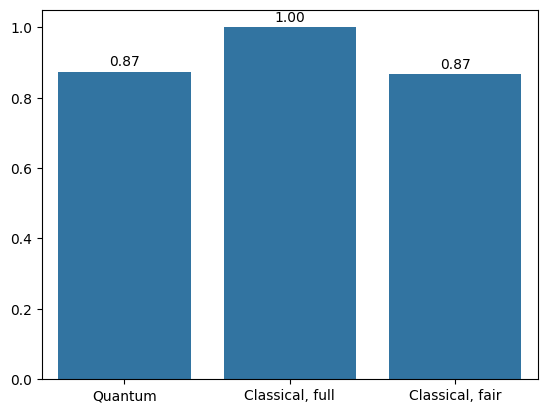

In [37]:
qnn_accuracy = qnn_results[1]
cnn_accuracy = cnn_results[1]
fair_nn_accuracy = fair_nn_results[1]

ax = sns.barplot(x=["Quantum", "Classical, full", "Classical, fair"],
            y=[qnn_accuracy, cnn_accuracy, fair_nn_accuracy])
for p in ax.patches:
    ax.annotate(format(p.get_height(), '.2f'),
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha = 'center', va = 'center',
                xytext = (0, 7),
                textcoords = 'offset points')
plt.show()

In [38]:
print("Quantum model accuracy:", qnn_accuracy)
print("Classical, full data model accuracy:", cnn_accuracy)
print("Classical, fair data model accuracy:", fair_nn_accuracy)

Quantum model accuracy: 0.8739919066429138
Classical, full data model accuracy: 1.0
Classical, fair data model accuracy: 0.8673780560493469


# Teste vários modelos clássicos

In [ ]:
filtered_images = {
    "Bilinear": x_test_bilinear,
    "Lanczos3": x_test_lanczos3,
    "Lanczos5": x_test_lanczos5,
    "Mitchellcubic": x_test_mitchellcubic,
    "Nearest": x_test_nearest,
    "Area": x_test_area,
    "Gaussian": x_test_gaussian,
    "Bicubic": x_test_bicubic,
    "Tent": x_test_hat_tent
}

In [39]:
def create_perceptron():
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Flatten(input_shape=(4,4,1)))
    model.add(tf.keras.layers.Dense(1))
    return model

model = create_perceptron()
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(),
              metrics=['accuracy'])

model.summary()

model.fit(x_train_bin,
            y_train_nocon,
            batch_size=128,
            epochs=20,
            verbose=2,
            validation_data=(x_test_bin, y_test))

perceptron_results = model.evaluate(x_test_bin, y_test)

perceptron_accuracy = perceptron_results[1]

print("Perceptron model accuracy:", perceptron_accuracy)

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_2 (Flatten)         (None, 16)                0         
                                                                 
 dense_4 (Dense)             (None, 1)                 17        
                                                                 
Total params: 17
Trainable params: 17
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
81/81 - 0s - loss: 0.7271 - accuracy: 0.4903 - val_loss: 0.6984 - val_accuracy: 0.5020 - 410ms/epoch - 5ms/step
Epoch 2/20
81/81 - 0s - loss: 0.6842 - accuracy: 0.5448 - val_loss: 0.6585 - val_accuracy: 0.5051 - 85ms/epoch - 1ms/step
Epoch 3/20
81/81 - 0s - loss: 0.6455 - accuracy: 0.5501 - val_loss: 0.6225 - val_accuracy: 0.5112 - 86ms/epoch - 1ms/step
Epoch 4/20
81/81 - 0s - loss: 0.6107 - accuracy: 0.5615 - val_loss: 0.5900 - val_accura

In [41]:
def create_multilayer_perceptron():
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Flatten(input_shape=(4,4,1)))
    model.add(tf.keras.layers.Dense(4, activation='relu'))
    model.add(tf.keras.layers.Dense(1))
    return model

model = create_multilayer_perceptron()
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(),
              metrics=['accuracy'])

model.summary()

model.fit(x_train_bin,
            y_train_nocon,
            batch_size=128,
            epochs=20,
            verbose=2,
            validation_data=(x_test_bin, y_test))

mlp_results = model.evaluate(x_test_bin, y_test)

mlp_accuracy = mlp_results[1]

print("Multilayer perceptron model accuracy:", mlp_accuracy)

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_4 (Flatten)         (None, 16)                0         
                                                                 
 dense_7 (Dense)             (None, 4)                 68        
                                                                 
 dense_8 (Dense)             (None, 1)                 5         
                                                                 
Total params: 73
Trainable params: 73
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
81/81 - 1s - loss: 0.5887 - accuracy: 0.6596 - val_loss: 0.5441 - val_accuracy: 0.6423 - 566ms/epoch - 7ms/step
Epoch 2/20
81/81 - 0s - loss: 0.5133 - accuracy: 0.7255 - val_loss: 0.4672 - val_accuracy: 0.7729 - 104ms/epoch - 1ms/step
Epoch 3/20
81/81 - 0s - loss: 0.4392 - accuracy: 0.8042 - val_loss: 0.3985 -

In [42]:
def create_convolutional_neural_network():
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Conv2D(4, [3, 3], activation='relu', input_shape=(4,4,1)))
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(1))
    return model

model = create_convolutional_neural_network()

model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

model.summary()

model.fit(x_train_bin,
            y_train_nocon,
            batch_size=128,
            epochs=20,
            verbose=2,
            validation_data=(x_test_bin, y_test))

cnn_results = model.evaluate(x_test_bin, y_test)

cnn_accuracy = cnn_results[1]

print("Convolutional neural network model accuracy:", cnn_accuracy)

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 2, 2, 4)           40        
                                                                 
 flatten_5 (Flatten)         (None, 16)                0         
                                                                 
 dense_9 (Dense)             (None, 1)                 17        
                                                                 
Total params: 57
Trainable params: 57
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
81/81 - 1s - loss: 0.6330 - accuracy: 0.6252 - val_loss: 0.5831 - val_accuracy: 0.6535 - 544ms/epoch - 7ms/step
Epoch 2/20
81/81 - 0s - loss: 0.5443 - accuracy: 0.7472 - val_loss: 0.4761 - val_accuracy: 0.7642 - 119ms/epoch - 1ms/step
Epoch 3/20
81/81 - 0s - loss: 0.4421 - accuracy: 0.8133 - val_loss: 0.3831 -

In [43]:
def create_recurrent_neural_network():
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.LSTM(4, input_shape=(4,4)))
    model.add(tf.keras.layers.Dense(1))
    return model

model = create_recurrent_neural_network()

model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

model.summary()

model.fit(x_train_bin,
            y_train_nocon,
            batch_size=128,
            epochs=20,
            verbose=2,
            validation_data=(x_test_bin, y_test))

rnn_results = model.evaluate(x_test_bin, y_test)

rnn_accuracy = rnn_results[1]

print("Recurrent neural network model accuracy:", rnn_accuracy)

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 4)                 144       
                                                                 
 dense_10 (Dense)            (None, 1)                 5         
                                                                 
Total params: 149
Trainable params: 149
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
81/81 - 2s - loss: 0.6843 - accuracy: 0.5249 - val_loss: 0.6724 - val_accuracy: 0.4868 - 2s/epoch - 23ms/step
Epoch 2/20
81/81 - 0s - loss: 0.6619 - accuracy: 0.5249 - val_loss: 0.6424 - val_accuracy: 0.4868 - 225ms/epoch - 3ms/step
Epoch 3/20
81/81 - 0s - loss: 0.6239 - accuracy: 0.5315 - val_loss: 0.5813 - val_accuracy: 0.4990 - 248ms/epoch - 3ms/step
Epoch 4/20
81/81 - 0s - loss: 0.5604 - accuracy: 0.6299 - val_loss: 0.5014 - val_accu

In [51]:
# Teste com o modelo de regressão logística, decision tree, random forest e SVM
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

x_train_flat = np.reshape(x_train_bin, (x_train_bin.shape[0], -1))
x_test_flat = np.reshape(x_test_bin, (x_test_bin.shape[0], -1))

# Logistic Regression
logreg = LogisticRegression()
logreg.fit(x_train_flat, y_train_nocon)
y_pred = logreg.predict(x_test_flat)
acc_logreg = round(logreg.score(x_train_flat, y_train_nocon) * 100, 2)
print("Logistic Regression accuracy is:", acc_logreg)

# Decision Tree
decision_tree = DecisionTreeClassifier()
decision_tree.fit(x_train_flat, y_train_nocon)
y_pred = decision_tree.predict(x_test_flat)
acc_decision_tree = round(decision_tree.score(x_train_flat, y_train_nocon) * 100, 2)
print("Decision Tree accuracy is:", acc_decision_tree)

# Random Forest
random_forest = RandomForestClassifier()
random_forest.fit(x_train_flat, y_train_nocon)
y_pred = random_forest.predict(x_test_flat)
acc_random_forest = round(random_forest.score(x_train_flat, y_train_nocon) * 100, 2)
print("Random Forest accuracy is:", acc_random_forest)

# SVM
from sklearn.svm import SVC
svm = SVC()
svm.fit(x_train_flat, y_train_nocon)
y_pred = svm.predict(x_test_flat)
acc_svm = round(svm.score(x_train_flat, y_train_nocon) * 100, 2)
print("SVM accuracy is:", acc_svm)

Logistic Regression accuracy is: 90.71
Decision Tree accuracy is: 90.92
Random Forest accuracy is: 90.92
SVM accuracy is: 90.85


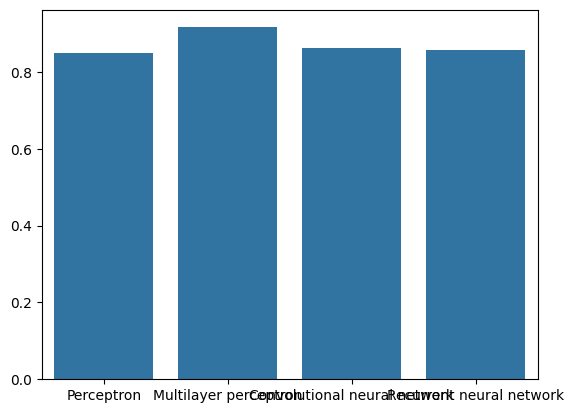

In [44]:
# Plot the accuracy of all the models.
ax = sns.barplot(x=["Perceptron", "Multilayer perceptron", "Convolutional neural network", "Recurrent neural network"],
            y=[perceptron_accuracy, mlp_accuracy, cnn_accuracy, rnn_accuracy])